In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from keras.layers import Input,Conv2D, BatchNormalization, Dense, LSTM,MaxPooling2D
from keras.layers import Reshape, Bidirectional, LSTM,Flatten, Dropout, Activation
from tensorflow.keras.utils import plot_model


from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import gc
import joblib

import warnings
warnings.filterwarnings('ignore')

In [2]:
def prep_df(df):
    df['genre_corr'] = df['genre'].apply(lambda x:'hip-hop' if x in ['hip-hop','rap'] else x)
    df['genre_corr'] = df['genre_corr'].apply(lambda x:'metal' if x in ['hardcore','Metal'] else x)
    df['genre_corr'] = df['genre_corr'].apply(lambda x:'rock' if x in ['rock','punk'] else x)
    df = df[~df.genre.isin(['indie', 'blues', 'alternative'])]
    return df

In [3]:
df_songs = pd.read_csv('../data/all_songs.csv')
df_songs = prep_df(df_songs)

In [4]:
df_songs.genre_corr.value_counts()

rock          640
hip-hop       616
metal         559
classical     464
Electronic    368
rnb           353
dance         345
jazz          304
reggae        301
acoustic      288
country       252
Name: genre_corr, dtype: int64

In [5]:
all_songs=[]
for file in df_songs.file_path.to_list():
    song = np.load(file+'.npy')
    if song.shape[1] >2881:
        song = song[:,:2881]
    elif song.shape[1] <2881:
        song = np.pad(song, ((0,0),(0,2881-song.shape[1])), 'constant')
    song = song.reshape(-1,1)
    all_songs.append(song)
X = np.array(all_songs)
X.shape

(4490, 368768, 1)

In [6]:
y = df_songs.genre_corr.astype('category').cat.codes.values
labels = df_songs.genre_corr.astype('category')
y.shape

(4490,)

In [7]:
scaler = MinMaxScaler(feature_range=(0, 1))
melspectrogram=X.reshape(X.shape[0],-1)
print(melspectrogram.shape)
scaler.fit(melspectrogram)
normalized_melspectrogram = scaler.transform(melspectrogram)
features_convolution = np.reshape(normalized_melspectrogram,(X.shape[0],128, -1,1))
joblib.dump(scaler, '../data/models/minmax_scaler.save')
features_convolution.shape[1:]

(4490, 368768)


(128, 2881, 1)

In [8]:
gc.collect()
X_train, X_test, y_train, y_test = train_test_split(features_convolution, y, test_size=0.2, random_state=42, )
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)
gc.collect()
X_train.shape,X_test.shape, X_val.shape

((3232, 128, 2881, 1), (898, 128, 2881, 1), (360, 128, 2881, 1))

In [9]:
def create_model(input_shape=(128, 2881, 1), num_classes=11, model_type = 'CNN', compile_model = False):
    model = keras.Sequential()
    
    def step(i,dim,pad,model):
        if i==0:          
            model.add(Conv2D(dim, kernel_size=(3, 3), input_shape = input_shape, name = 'First_Convolution'))
        else:
            model.add(Conv2D(dim, kernel_size=(3, 3)))      
       
        model.add(BatchNormalization(axis=3))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pad, padding= 'same'))
        model.add(Dropout(0.1))
        
        return model

    layer_dims = [64, 128, 128, 128]
    pads = [(2,2), (3,3), (4,4), (4,4)]
    for (i,dim),pad in zip(enumerate(layer_dims), pads):
        model = step(i,dim,pad, model)
    if model_type == 'CNN':
        model.add(Flatten())
        model.add(Dense(num_classes))
        model.add(Activation('softmax'))
    if model_type =='CRNN':
        fin_layer_shape = model.layers[-1].output_shape
        model.add(Reshape((fin_layer_shape[3], fin_layer_shape[2])))
        model.add(Bidirectional(LSTM(128, input_shape=(1,128, 30), return_sequences=True, )))
        model.add(Bidirectional(LSTM(64, input_shape=(1,128,30), return_sequences=False)))
        model.add(Dense(num_classes))
        model.add(Activation('softmax'))
    if compile_model:
        model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
    return model
    

In [10]:
def create_model_checkpoint(model_name):
    checkpoint_filepath = '../data/models/{}/'.format(model_name)
    os.makedirs(checkpoint_filepath, exist_ok=True)
    model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True)
    return model_checkpoint_callback

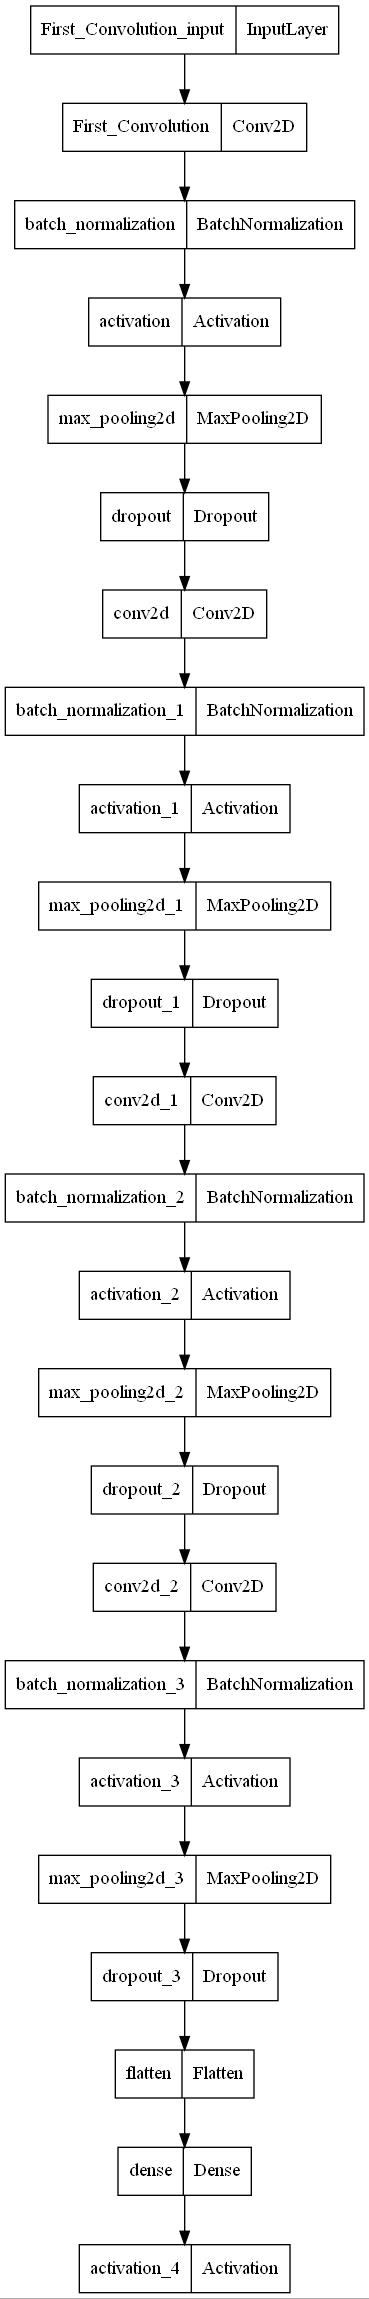

In [11]:
cnn_model = create_model( model_type = 'CNN', compile_model=False)
plot_model(cnn_model, to_file='../data/images/cnn_model.jpg')

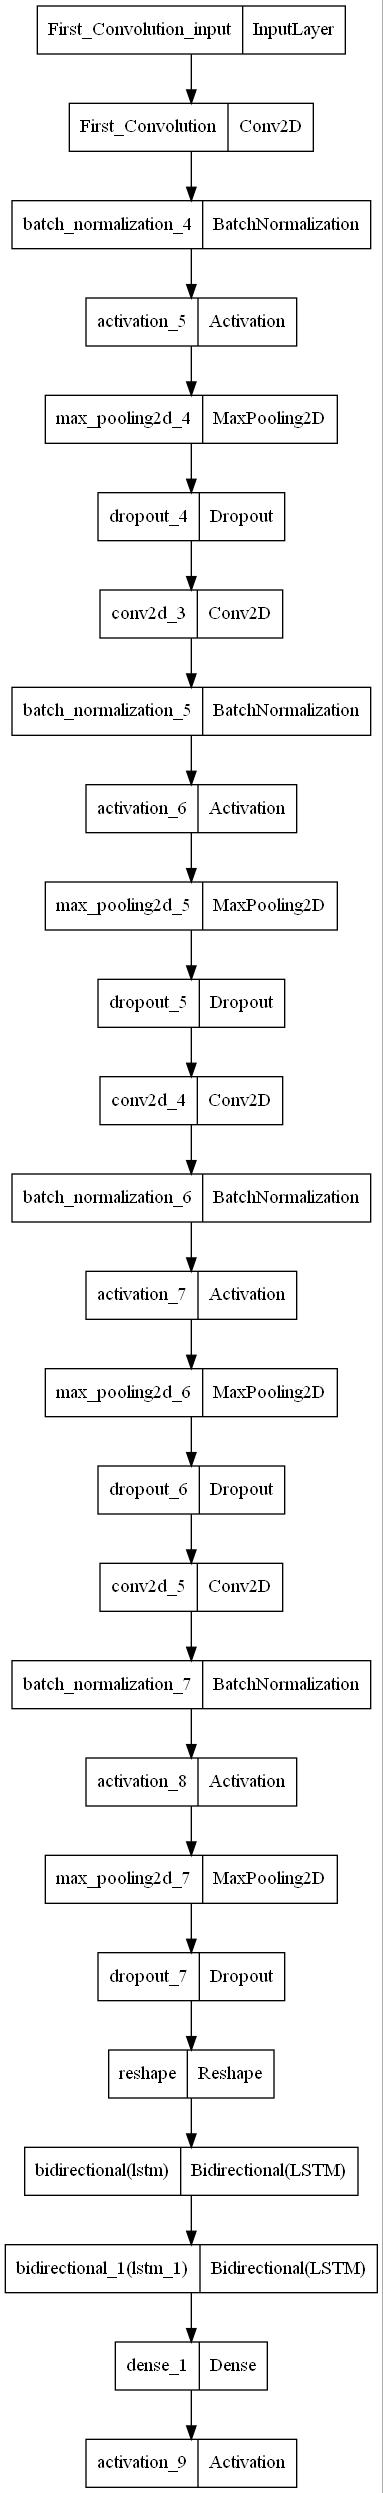

In [12]:
crnn_model = create_model( model_type = 'CRNN', compile_model=False)
plot_model(crnn_model, to_file='../data/images/crnn_model.jpg')

In [13]:
cnn_model = create_model( model_type = 'CNN', compile_model=True)
crnn_model = create_model( model_type = 'CRNN', compile_model=True)

epochs = 75
batch_size = 16
cnn_model_checkpoint = create_model_checkpoint('CNN')
history_cnn = cnn_model.fit(X_train, y_train, epochs=epochs, validation_data=[X_val, y_val], 
                             verbose = 2, batch_size = batch_size, callbacks =[cnn_model_checkpoint] )
gc.collect()
crnn_model_checkpoint = create_model_checkpoint('CRNN')
history_crnn = crnn_model.fit(X_train, y_train, epochs=epochs, validation_data=[X_val, y_val], 
                             verbose = 2, batch_size = batch_size, callbacks =[crnn_model_checkpoint] )

Epoch 1/75
202/202 - 63s - loss: 2.3816 - accuracy: 0.3082 - val_loss: 6.1661 - val_accuracy: 0.1000 - 63s/epoch - 312ms/step
Epoch 2/75
202/202 - 50s - loss: 1.8286 - accuracy: 0.4131 - val_loss: 6.6463 - val_accuracy: 0.1000 - 50s/epoch - 245ms/step
Epoch 3/75
202/202 - 50s - loss: 1.6373 - accuracy: 0.4817 - val_loss: 2.4424 - val_accuracy: 0.2667 - 50s/epoch - 247ms/step
Epoch 4/75
202/202 - 50s - loss: 1.4428 - accuracy: 0.5195 - val_loss: 5.4002 - val_accuracy: 0.2806 - 50s/epoch - 246ms/step
Epoch 5/75
202/202 - 50s - loss: 1.3222 - accuracy: 0.5675 - val_loss: 3.7946 - val_accuracy: 0.1944 - 50s/epoch - 246ms/step
Epoch 6/75
202/202 - 50s - loss: 1.2076 - accuracy: 0.5978 - val_loss: 2.0890 - val_accuracy: 0.3889 - 50s/epoch - 246ms/step
Epoch 7/75
202/202 - 50s - loss: 1.0188 - accuracy: 0.6597 - val_loss: 1.9131 - val_accuracy: 0.4889 - 50s/epoch - 246ms/step
Epoch 8/75
202/202 - 50s - loss: 0.9873 - accuracy: 0.6677 - val_loss: 3.0436 - val_accuracy: 0.3639 - 50s/epoch - 247

Epoch 66/75
202/202 - 50s - loss: 0.1621 - accuracy: 0.9431 - val_loss: 1.3783 - val_accuracy: 0.6750 - 50s/epoch - 248ms/step
Epoch 67/75
202/202 - 50s - loss: 0.1691 - accuracy: 0.9403 - val_loss: 1.5338 - val_accuracy: 0.6139 - 50s/epoch - 248ms/step
Epoch 68/75
202/202 - 50s - loss: 0.1656 - accuracy: 0.9437 - val_loss: 2.1526 - val_accuracy: 0.5472 - 50s/epoch - 248ms/step
Epoch 69/75
202/202 - 50s - loss: 0.1635 - accuracy: 0.9431 - val_loss: 1.4948 - val_accuracy: 0.6222 - 50s/epoch - 248ms/step
Epoch 70/75
202/202 - 50s - loss: 0.1653 - accuracy: 0.9443 - val_loss: 1.9840 - val_accuracy: 0.5472 - 50s/epoch - 248ms/step
Epoch 71/75
202/202 - 50s - loss: 0.1681 - accuracy: 0.9415 - val_loss: 1.2515 - val_accuracy: 0.6917 - 50s/epoch - 248ms/step
Epoch 72/75
202/202 - 50s - loss: 0.1679 - accuracy: 0.9403 - val_loss: 1.0212 - val_accuracy: 0.7389 - 50s/epoch - 248ms/step
Epoch 73/75
202/202 - 50s - loss: 0.1677 - accuracy: 0.9446 - val_loss: 1.2708 - val_accuracy: 0.5833 - 50s/epo

Epoch 56/75
202/202 - 55s - loss: 0.1842 - accuracy: 0.9239 - val_loss: 1.9077 - val_accuracy: 0.5222 - 55s/epoch - 275ms/step
Epoch 57/75
202/202 - 55s - loss: 0.1827 - accuracy: 0.9304 - val_loss: 1.5552 - val_accuracy: 0.6472 - 55s/epoch - 275ms/step
Epoch 58/75
202/202 - 55s - loss: 0.1856 - accuracy: 0.9242 - val_loss: 1.9616 - val_accuracy: 0.5361 - 55s/epoch - 274ms/step
Epoch 59/75
202/202 - 55s - loss: 0.2029 - accuracy: 0.9180 - val_loss: 1.3825 - val_accuracy: 0.6806 - 55s/epoch - 275ms/step
Epoch 60/75
202/202 - 56s - loss: 0.2011 - accuracy: 0.9199 - val_loss: 1.9576 - val_accuracy: 0.5722 - 56s/epoch - 277ms/step
Epoch 61/75
202/202 - 56s - loss: 0.1972 - accuracy: 0.9223 - val_loss: 1.8779 - val_accuracy: 0.5917 - 56s/epoch - 278ms/step
Epoch 62/75
202/202 - 56s - loss: 0.1754 - accuracy: 0.9285 - val_loss: 2.4522 - val_accuracy: 0.4250 - 56s/epoch - 277ms/step
Epoch 63/75
202/202 - 56s - loss: 0.1892 - accuracy: 0.9230 - val_loss: 1.6259 - val_accuracy: 0.5722 - 56s/epo

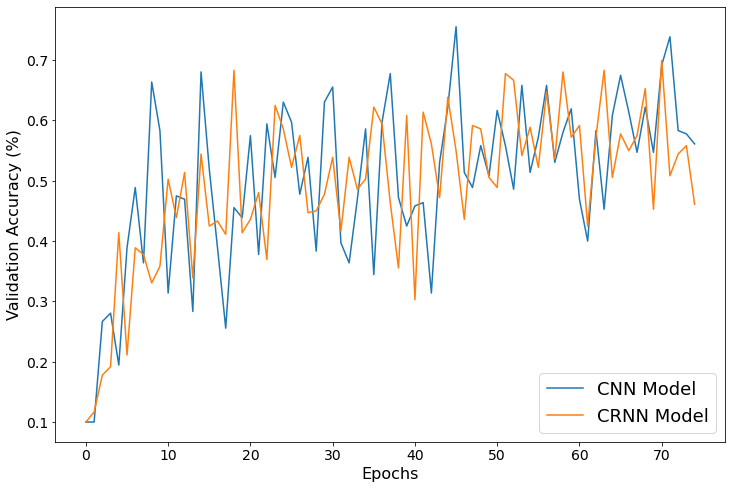

In [15]:
plt.figure(figsize = (12,8))
pd.DataFrame(history_cnn.history)['val_accuracy'].plot(label='CNN Model')
pd.DataFrame(history_crnn.history)['val_accuracy'].plot(label= 'CRNN Model')
plt.legend(fontsize = 18)
plt.xlabel('Epochs', fontsize = 16)
plt.ylabel('Validation Accuracy (%)', fontsize = 16)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.show()

In [16]:
gc.collect()
cnn_model.load_weights(cnn_model_checkpoint.filepath)
crnn_model.load_weights(crnn_model_checkpoint.filepath)
pred_cnn = np.argmax( cnn_model.predict(X_test), axis=1)
accuracy_cnn = np.round(accuracy_score(y_test,pred_cnn)*100,2)
pred_crnn = np.argmax( crnn_model.predict(X_test), axis=1)
accuracy_crnn = np.round(accuracy_score(y_test,pred_crnn)*100,2)
print('The accuracy of CNN model is {}% and CRNN Model is {}%'.format(accuracy_cnn,accuracy_crnn))

The accuracy of CNN model is 68.49% and CRNN Model is 63.47%


In [17]:
def plot_heatmap_mat(y_test,pred,classes,normalize=False, ax=None ):
    sns.set_context("poster", rc={"font.size":14, 'figure.facecolor':'w'})
    sns.set({'figure.facecolor':'w'})
    conf_mx = confusion_matrix(y_test,pred)
    if normalize:
        row_sums = conf_mx.sum(axis=1, keepdims=True)
        norm_conf_mx = conf_mx / row_sums
        plot = sns.heatmap(norm_conf_mx, annot=True, square=True,
                    xticklabels=classes,yticklabels=classes, fmt='.2f',cbar_kws={"shrink": 0.5},
                    linewidths=.1, ax=ax,annot_kws={"fontsize":12})
        cbar = ax.collections[0].colorbar
        cbar.ax.tick_params(labelsize=14)
        ax.tick_params('both', labelsize=14)
        ax.set_ylabel('Actual label', fontsize = 16)
        ax.set_xlabel('Predicted label', fontsize = 16)
        return plot
    else:
        plot = sns.heatmap(conf_mx, annot=True, square=True,
                    xticklabels=classes,yticklabels=classes,fmt='d',cbar_kws={"shrink": 0.5},
                    linewidths=.2, ax= ax,annot_kws={"fontsize":12})
        cbar = ax.collections[0].colorbar
        cbar.ax.tick_params(labelsize=14)
        ax.tick_params('both', labelsize=14)
        plt.yticks(fontsize=14)
        ax.set_ylabel('Actual label', fontsize = 16)
        ax.set_xlabel('Predicted label', fontsize = 16)
        return plot

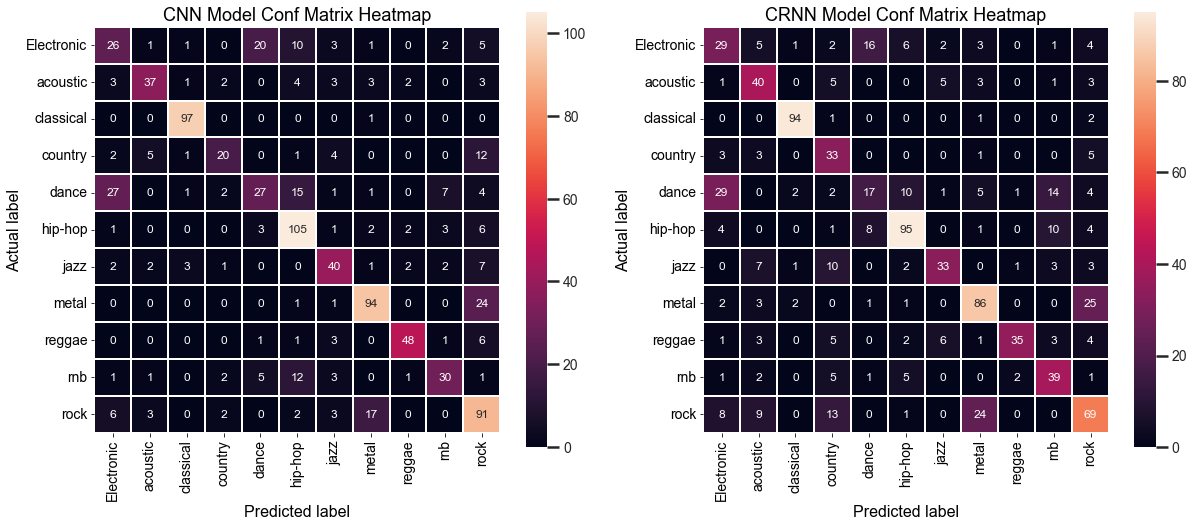

In [18]:
fig, [ax1,ax2] = plt.subplots( nrows = 1, ncols = 2,figsize=(20,16),facecolor='white')

plot_heatmap_mat(y_test,pred_cnn,normalize=False,classes =list(labels.cat.categories), ax=ax1)
ax1.set_title('CNN Model Conf Matrix Heatmap', fontsize = 18)
plot_heatmap_mat(y_test,pred_crnn,normalize=False,classes =list(labels.cat.categories), ax=ax2)
ax2.set_title('CRNN Model Conf Matrix Heatmap', fontsize = 18)
plt.show()

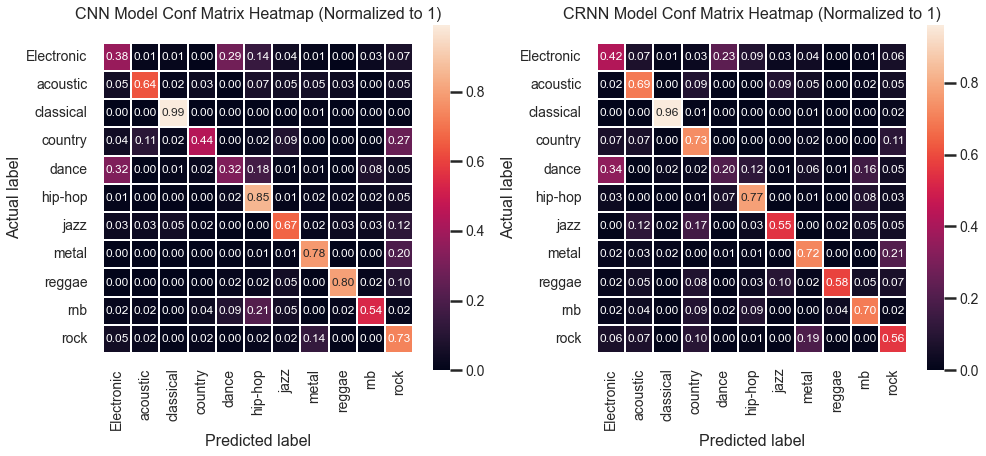

In [19]:
fig, [ax1,ax2] = plt.subplots( nrows = 1, ncols = 2,figsize=(14,10),facecolor='white')

plot_heatmap_mat(y_test,pred_cnn,normalize=True,classes =list(labels.cat.categories), ax=ax1)
ax1.set_title('CNN Model Conf Matrix Heatmap (Normalized to 1)\n', fontsize = 16)

plot_heatmap_mat(y_test,pred_crnn,normalize=True,classes =list(labels.cat.categories), ax=ax2)
ax2.set_title('CRNN Model Conf Matrix Heatmap (Normalized to 1)\n', fontsize = 16)
plt.tight_layout()
plt.savefig('../data/images/model_comparison_norm_heatmap.jpg', dpi=300, format = 'jpg',bbox_inches='tight')
